In [3]:
!ls /mnt/chicm/open-images-seg/notebooks

check_preds.ipynb	  merge_df.ipynb	     submit.ipynb
check_preds-parent.ipynb  sub_4195_100_275_5000.csv  submit-parent.ipynb
eda.ipynb		  sub_4195_100_275.csv	     top_classes.csv
ensemble_csv.ipynb	  sub_4195_100_276.csv	     top_classes_level1.csv
ensemble.ipynb		  sub_4195_20_100_5000.csv   top_classes_parent.csv
filter_classes.ipynb	  sub_4195_20_100.csv	     train_parent.ipynb


In [144]:
import pandas as pd
import numpy as np
import os
import pycocotools.mask as mutils
import base64
import numpy as np
from pycocotools import mask as coco_mask_d
import typing as t
import zlib
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm


In [99]:
csv_files = [
    '/mnt/chicm/open-images-seg/notebooks/sub_4195_100_275_5000.csv',
    '/mnt/chicm/open-images-seg/notebooks/sub_4195_20_100.csv'
]

In [118]:
ens_weights = [0.6, 0.4]

In [101]:
dfs = [pd.read_csv(fn) for fn in csv_files]

In [102]:
for df in dfs:
   df.PredictionString = df.PredictionString.fillna('') 

In [125]:
dfs[0].head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,/m/03grzl 0.0011774 eNp9U9tSwyAQ/SUgJHFGiVNeGs...
1,52a76f3fe21185bf,1024,683,/m/016m2d 0.8576992 eNrFjt0OgjAMhV+pHSEkam/mX+...
2,65e9da7c04c8e4cd,1024,682,
3,6d10fa21d93bd6cc,1024,682,
4,0841dee573a875ca,1024,683,/m/06_fw 0.0487942 eNptUsEOwjAI/SVauoOJf7BRrho...


In [128]:
def decode_mask(mask, h, w):
    mask = base64.b64decode(mask)
    mask = zlib.decompress(mask)
    decoding_dict = {
          'size': [h, w],
          'counts': mask
    }
    mask_tensor = coco_mask_d.decode(decoding_dict)

    #print(type(mask_tensor))
    return mask_tensor

In [129]:
tmp_mask1 = decode_mask(dfs[0].iloc[0].PredictionString.split(' ')[2], 683, 1024)

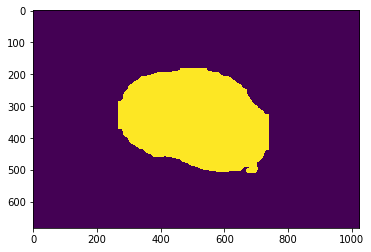

In [130]:
plt.imshow(tmp_mask1)

In [140]:
MAX_NUM = 160

def get_dets(df, i):
    row = df.iloc[i]
    items = row.PredictionString.split(' ')
    dets = []
    det = []
    for i, item in enumerate(items):
        if i % 3 == 0:
            det = []
        det.append(item)
        
        if (i+1) % 3 == 0:
            #print('mask====>', det[2])
            mask = decode_mask(det[2], row.ImageHeight, row.ImageWidth)
            dets.append([mask, det[0], float(det[1])])

    return dets

def get_ens_det(idx):
    dets = [get_dets(df, idx) for df in dfs]

    ens_det = general_ensemble(dets, weights=ens_weights)
    ens_det = [[encode_binary_mask(x[0].astype(np.bool)), x[1], x[2]] for x in ens_det]

    return sorted(ens_det, key=lambda x: x[2], reverse=True)[:MAX_NUM]


In [141]:
for i in range(10):
    get_dets(dfs[0], i)

In [142]:
len(dfs[0])

99999

In [148]:
from multiprocessing import Pool
import time

bg = time.time()

with Pool(24) as p:
    num_imgs = 10# len(dfs[0])
    ens_dets = p.map(get_ens_det, range(num_imgs))

    
print('total time:', (time.time()-bg)/60) 

total time: 0.007234787940979004


In [154]:
def get_pred_str(idx):
    if idx >= len(ens_dets):
        return ''
    res = []
    for det in ens_dets[idx]:
        res.append(det[1])
        res.append('{:.7f}'.format(det[2]))
        #res.append(encode_binary_mask(det[0].astype(np.bool)))
        res.append(det[0])

    return ' '.join(res)

def set_pred_str(df):
    df['PredictionString'] = df.img_index.map(lambda x: get_pred_str(x))
    return df


In [155]:

print('creating submission...')
df_test = pd.read_csv(os.path.join(DATA_DIR, 'sample_empty_submission.csv'))
df_test['img_index'] = df_test.index
df_test = parallel_apply(df_test, set_pred_str)
df_test = df_test.drop(columns=['img_index'], axis=1)

#df_test.to_csv(args.out, index=False)


creating submission...


In [156]:
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,/m/01k6s3 0.0777893 eNp1U21vwiAQ/ktAabf2Q5N+aL...
1,52a76f3fe21185bf,1024,683,/m/016m2d 0.4288496 eNrFjt0OgjAMhV+pHSEkam/mX+...
2,65e9da7c04c8e4cd,1024,682,
3,6d10fa21d93bd6cc,1024,682,/m/01n4qj 0.0222106 eNqFU21vgjAQ/kulRRvYSzIzDB...
4,0841dee573a875ca,1024,683,/m/06_fw 0.0243971 eNptUsEOwjAI/SVauoOJf7BRrho...


In [152]:
def parallel_apply(df, func, n_cores=24):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [134]:
def general_ensemble(dets, iou_thresh = 0.5, weights=None):
    assert(type(iou_thresh) == float)
    
    ndets = len(dets)
    
    if weights is None:
        w = 1/float(ndets)
        weights = [w]*ndets
    else:
        assert(len(weights) == ndets)
        
        s = sum(weights)
        for i in range(0, len(weights)):
            weights[i] /= s

    out = list()
    used = list()
    
    for idet in range(0,ndets):
        det = dets[idet]
        for box in det:
            if box[2] in used:
                continue
                
            used.append(box[2])
            # Search the other detectors for overlapping box of same class
            found = []
            for iodet in range(0, ndets):
                odet = dets[iodet]
                
                if iodet == idet:
                    continue
                
                bestbox = None
                bestiou = iou_thresh
                for obox in odet:
                    if not obox[2] in used:
                        # Not already used
                        if box[1] == obox[1]:
                            # Same class
                            iou = computeIOU(box[0], obox[0])
                            if iou > bestiou:
                                bestiou = iou
                                bestbox = obox
                                
                if not bestbox is None:
                    w = weights[iodet]
                    found.append((bestbox,w))
                    used.append(bestbox[2])
                            
            # Now we've gone through all other detectors
            if len(found) == 0:
                new_box = list(box)
                new_box[2] /= ndets
                out.append(new_box)
            else:
                allboxes = [(box, weights[idet])]
                allboxes.extend(found)
                
                conf = 0.0
                
                wsum = 0.0
                masks = []
                for bb in allboxes:
                    w = bb[1]
                    wsum += w
                    b = bb[0]
                    conf += w*b[2]
                    masks.append(b[0].astype(np.float32))
                
                new_mask = (np.mean(masks, 0) > 0.51).astype(np.uint8)
                new_box = [new_mask, box[1], conf]
                out.append(new_box)
    return out


def computeIOU(mask1, mask2):
    
    intersect_area = ((mask1 * mask2) > 0).sum()
    
    iou = intersect_area / ((mask1 + mask2) > 0).sum()
    return iou


In [147]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)
    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')


In [68]:
# Copyright 2018 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
r"""Converts data from CSV to the OpenImagesDetectionChallengeEvaluator format."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import zlib

import numpy as np
import pandas as pd
from pycocotools import mask as coco_mask

from object_detection.core import standard_fields


def _to_normalized_box(mask_np):
  """Decodes binary segmentation masks into np.arrays and boxes.

  Args:
    mask_np: np.ndarray of size NxWxH.

  Returns:
    a np.ndarray of the size Nx4, each row containing normalized coordinates
    [YMin, XMin, YMax, XMax] of a box computed of axis parallel enclosing box of
    a mask.
  """
  coord1, coord2 = np.nonzero(mask_np)
  if coord1.size > 0:
    ymin = float(min(coord1)) / mask_np.shape[0]
    ymax = float(max(coord1) + 1) / mask_np.shape[0]
    xmin = float(min(coord2)) / mask_np.shape[1]
    xmax = float((max(coord2) + 1)) / mask_np.shape[1]

    return np.array([ymin, xmin, ymax, xmax])
  else:
    return np.array([0.0, 0.0, 0.0, 0.0])


def _decode_raw_data_into_masks_and_boxes(segments, image_widths,
                                          image_heights):
  """Decods binary segmentation masks into np.arrays and boxes.

  Args:
    segments: pandas Series object containing either
      None entries, or strings with
      base64, zlib compressed, COCO RLE-encoded binary masks.
      All masks are expected to be the same size.
    image_widths: pandas Series of mask widths.
    image_heights: pandas Series of mask heights.

  Returns:
    a np.ndarray of the size NxWxH, where W and H is determined from the encoded
    masks; for the None values, zero arrays of size WxH are created. If input
    contains only None values, W=1, H=1.
  """
  segment_masks = []
  segment_boxes = []
  ind = segments.first_valid_index()
  if ind is not None:
    size = [int(image_heights[ind]), int(image_widths[ind])]
  else:
    # It does not matter which size we pick since no masks will ever be
    # evaluated.
    return np.zeros((segments.shape[0], 1, 1), dtype=np.uint8), np.zeros(
        (segments.shape[0], 4), dtype=np.float32)

  for segment, im_width, im_height in zip(segments, image_widths,
                                          image_heights):
    if pd.isnull(segment):
      segment_masks.append(np.zeros([1, size[0], size[1]], dtype=np.uint8))
      segment_boxes.append(np.expand_dims(np.array([0.0, 0.0, 0.0, 0.0]), 0))
    else:
      compressed_mask = base64.b64decode(segment)
      rle_encoded_mask = zlib.decompress(compressed_mask)
      decoding_dict = {
          'size': [im_height, im_width],
          'counts': rle_encoded_mask
      }
      mask_tensor = coco_mask.decode(decoding_dict)

      segment_masks.append(np.expand_dims(mask_tensor, 0))
      segment_boxes.append(np.expand_dims(_to_normalized_box(mask_tensor), 0))

  return np.concatenate(
      segment_masks, axis=0), np.concatenate(
          segment_boxes, axis=0)


def merge_boxes_and_masks(box_data, mask_data):
  return pd.merge(
      box_data,
      mask_data,
      how='outer',
      on=['LabelName', 'ImageID', 'XMin', 'XMax', 'YMin', 'YMax', 'IsGroupOf'])


def build_groundtruth_dictionary(data, class_label_map):
  """Builds a groundtruth dictionary from groundtruth data in CSV file.

  Args:
    data: Pandas DataFrame with the groundtruth data for a single image.
    class_label_map: Class labelmap from string label name to an integer.

  Returns:
    A dictionary with keys suitable for passing to
    OpenImagesDetectionChallengeEvaluator.add_single_ground_truth_image_info:
        standard_fields.InputDataFields.groundtruth_boxes: float32 numpy array
          of shape [num_boxes, 4] containing `num_boxes` groundtruth boxes of
          the format [ymin, xmin, ymax, xmax] in absolute image coordinates.
        standard_fields.InputDataFields.groundtruth_classes: integer numpy array
          of shape [num_boxes] containing 1-indexed groundtruth classes for the
          boxes.
        standard_fields.InputDataFields.verified_labels: integer 1D numpy array
          containing all classes for which labels are verified.
        standard_fields.InputDataFields.groundtruth_group_of: Optional length
          M numpy boolean array denoting whether a groundtruth box contains a
          group of instances.
  """
  data_location = data[data.XMin.notnull()]
  data_labels = data[data.ConfidenceImageLabel.notnull()]

  dictionary = {
      standard_fields.InputDataFields.groundtruth_boxes:
          data_location[['YMin', 'XMin', 'YMax', 'XMax']].as_matrix(),
      standard_fields.InputDataFields.groundtruth_classes:
          data_location['LabelName'].map(lambda x: class_label_map[x]
                                        ).as_matrix(),
      standard_fields.InputDataFields.groundtruth_group_of:
          data_location['IsGroupOf'].as_matrix().astype(int),
      standard_fields.InputDataFields.groundtruth_image_classes:
          data_labels['LabelName'].map(lambda x: class_label_map[x]
                                      ).as_matrix(),
  }

  if 'Mask' in data_location:
    segments, _ = _decode_raw_data_into_masks_and_boxes(
        data_location['Mask'], data_location['ImageWidth'],
        data_location['ImageHeight'])
    dictionary[
        standard_fields.InputDataFields.groundtruth_instance_masks] = segments

  return dictionary


def build_predictions_dictionary(data, class_label_map):
  """Builds a predictions dictionary from predictions data in CSV file.

  Args:
    data: Pandas DataFrame with the predictions data for a single image.
    class_label_map: Class labelmap from string label name to an integer.

  Returns:
    Dictionary with keys suitable for passing to
    OpenImagesDetectionChallengeEvaluator.add_single_detected_image_info:
        standard_fields.DetectionResultFields.detection_boxes: float32 numpy
          array of shape [num_boxes, 4] containing `num_boxes` detection boxes
          of the format [ymin, xmin, ymax, xmax] in absolute image coordinates.
        standard_fields.DetectionResultFields.detection_scores: float32 numpy
          array of shape [num_boxes] containing detection scores for the boxes.
        standard_fields.DetectionResultFields.detection_classes: integer numpy
          array of shape [num_boxes] containing 1-indexed detection classes for
          the boxes.

  """
  dictionary = {
      standard_fields.DetectionResultFields.detection_classes:
          data['LabelName'].map(lambda x: class_label_map[x]).as_matrix(),
      standard_fields.DetectionResultFields.detection_scores:
          data['Score'].as_matrix()
  }

  if 'Mask' in data:
    segments, boxes = _decode_raw_data_into_masks_and_boxes(
        data['Mask'], data['ImageWidth'], data['ImageHeight'])
    dictionary[standard_fields.DetectionResultFields.detection_masks] = segments
    dictionary[standard_fields.DetectionResultFields.detection_boxes] = boxes
  else:
    dictionary[standard_fields.DetectionResultFields.detection_boxes] = data[[
        'YMin', 'XMin', 'YMax', 'XMax'
    ]].as_matrix()

  return dictionary

In [88]:
DATA_DIR = '/mnt/chicm/data/open-images/segmentation'
df_sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_empty_submission.csv'))
df_sub.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,-1,-1,NaN
1,52a76f3fe21185bf,-1,-1,NaN
2,65e9da7c04c8e4cd,-1,-1,NaN
3,6d10fa21d93bd6cc,-1,-1,NaN
4,0841dee573a875ca,-1,-1,NaN


In [93]:
df_pred = pd.read_csv('sub_4195_100_275.csv')
df_pred.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,/m/03grzl 0.0011774 eNp9U9tSwyAQ/SUgJHFGiVNeGs...
1,52a76f3fe21185bf,1024,683,/m/016m2d 0.8576992 eNrFjt0OgjAMhV+pHSEkam/mX+...
2,65e9da7c04c8e4cd,1024,682,NaN
3,6d10fa21d93bd6cc,1024,682,NaN
4,0841dee573a875ca,1024,683,/m/06_fw 0.0487942 eNptUsEOwjAI/SVauoOJf7BRrho...


In [94]:
df_pred.PredictionString=''
df_pred.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,
1,52a76f3fe21185bf,1024,683,
2,65e9da7c04c8e4cd,1024,682,
3,6d10fa21d93bd6cc,1024,682,
4,0841dee573a875ca,1024,683,


In [95]:
df_pred.shape

(99999, 4)

In [96]:
df_pred.to_csv(os.path.join(DATA_DIR, 'sample_empty_submission.csv'), index=False)